In [54]:
#import everything here
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt

## Calculating the Simple moving average(SMA) of an asset Close price over a period 
## Upper/Lower Bands = Multipler *  S.D. from the middle band

**Strategy:**
1. Buy signal  = everytime the Close price crosses the Lower Band
2. Then hold the asset until there is a Sell signal
3.  Sell signal = when the Close price crosses the Upper band (no short sellings)

In [55]:
#API data import

quandl.ApiConfig.api_key = "fYkH3s6N_8cAWa98E-JH"  #To ensure that my requests to Quandl are authenticated
API_key = "fYkH3s6N_8cAWa98E-JH"  #will be imported to git.ignore later

#curl "https://www.quandl.com/api/v3/datasets/WIKI/FB.json?column_index=4&start_date=2014-01-01&end_date=2014-12-31&collapse=monthly&transform=rdiff&api_key=YOURAPIKEY"

#End of day prices, indices, and additional information for companies trading on 
#the Bombay Stock Exchange in India.

meta_data = pd.read_csv('BSE_metadata.csv') #read meta data so we can understand the API request convention more easily
print(meta_data)

           code                                              name  \
0     BOM500002                      ABB India Limited EOD Prices   
1     BOM500003                   AEGIS LOGISTICS LTD. EOD Prices   
2     BOM500008              AMARA RAJA BATTERIES LTD. EOD Prices   
3     BOM500009      AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices   
4     BOM500010  HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices   
...         ...                                               ...   
5117   SPBSS5IP                                     BSE SENSEX 50   
5118   SPBSSSIP                         BSE SmallCap Select Index   
5119   SPBSTLIP                                       BSE Telecom   
5120   SPBSUTIP                                     BSE Utilities   
5121   SPICBLOT                             BSE Liquid Rate Index   

                                            description         refreshed_at  \
0     End of Day prices and additional trading infor...  2023-09-01 14:24:43   
1     End o

In [56]:
#Calling the data for calculating SMA
data = quandl.get('BSE/SENSEX', start_date='2009-10-05', end_date='2019-10-05') #SENSEX = the most widely traded indian index
print(data)

                Open      High       Low     Close
Date                                              
2009-10-05  17062.01  17062.01  16835.80  16866.41
2009-10-06  16879.38  16988.56  16622.05  16958.54
2009-10-07  17069.42  17120.56  16764.07  16806.66
2009-10-08  16908.02  16998.52  16775.36  16843.54
2009-10-09  16915.96  16963.08  16606.95  16642.66
...              ...       ...       ...       ...
2019-09-27  39003.13  39107.37  38782.60  38822.57
2019-09-30  38873.12  38873.12  38401.09  38667.33
2019-10-01  38813.48  38923.78  37929.89  38305.41
2019-10-03  38137.87  38310.93  37957.56  38106.87
2019-10-04  38401.49  38403.54  37633.36  37673.31

[2480 rows x 4 columns]


## A simple moving average is calculated by adding up the last “X” period’s closing prices and then dividing that number by X.

The period and SD multipler are adjustable variables.

/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/670958787.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(df.index.to_numpy(), df.Close.to_numpy(),"r--",linestyle='solid')
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/670958787.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(df.index.to_numpy(), df.Upper_Band.to_numpy(),"b--",linestyle='solid')
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/670958787.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(df.index.to_numpy(), df.Lower_Band.to_numpy(),"b--",linestyle='solid')


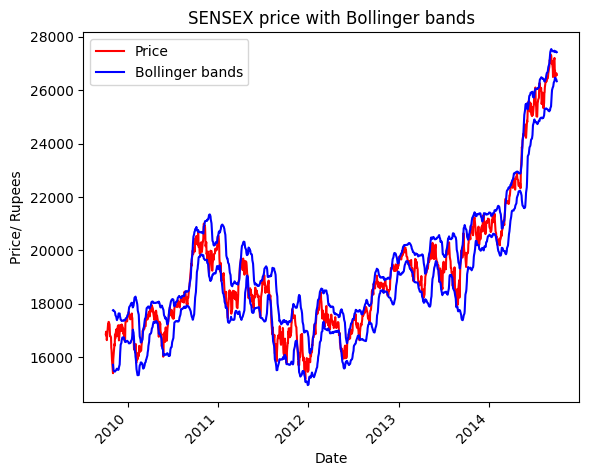

In [57]:
# Function calculating the SMA 
# Load historical price data into a DataFrame

# Load from 2009 to 2014 for visual illustration purposes
# Initialise these parameters for easyness when calling in different places 
Start_year = 2009 ; End_year = 2014
df = quandl.get('BSE/SENSEX', start_date=f'{Start_year}-10-05', end_date=f'{End_year}-10-05')

# Define the period and standard deviation multiplier
period = 20  # 20 days is apparently a medium-term indicator.
std_multiplier = 2  # Multiplier for standard deviation

# Calculate the rolling mean (middle band) and rolling standard deviation

# Calculates the rolling mean of the closing price by 
# Creating a rolling window of 'period'length and calculating the mean value within each window.
df['Middle_Band'] = df['Close'].rolling(window=period).mean()


# Calculate the Upper and Lower bands as they are multipler * SD away from the Middle band
df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(window=period).std() * std_multiplier)
df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(window=period).std() * std_multiplier)


# Plot the price with the bands to see that the code works as anticipated and there are reasonable number of crossings

plt.title("SENSEX price with Bollinger bands")
plt.plot(df.index.to_numpy(), df.Close.to_numpy(),"r--",linestyle='solid')
#plt.plot(df.index.to_numpy(), df.Middle_Band.to_numpy(),"r--",linestyle='dotted')
plt.plot(df.index.to_numpy(), df.Upper_Band.to_numpy(),"b--",linestyle='solid')
plt.plot(df.index.to_numpy(), df.Lower_Band.to_numpy(),"b--",linestyle='solid')
plt.legend(["Price","Bollinger bands"])
plt.xlabel("Date")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Price/ Rupees")
plt.show()


## Generate Buy and Sell signals according to the pre-planned strategies
### Add Cash_invested, Asset_owned and Asset_sold columns for simplicity in return calculation later on

In [58]:
# Generate buy and sell signals

df['Signal'] = 0  # Initialize signal column
df['Asset_owned'] = 0 # Initialize Asset owned column
df['Cash'] = 0 # Initialize Cash column
df['Cash_invested'] = 0 # Initialize Cash_invested column
df['Asset_sold'] = 0 #Initialize Cash_sold column

# Buy signal: Price crosses below the lower Bollinger Band
# Negative to our ledger because we're buying (putting money in)
df.loc[df['Close'] < df['Lower_Band'], 'Signal'] = -1 
df['Asset_owned'] = df['Signal'].cumsum() *(-1)
df.loc[df['Close'] < df['Lower_Band'], 'Cash_invested'] = df['Close'] * df['Signal'] 
df['Cash_invested'] = df['Cash_invested'].cumsum() *(-1) #make it cumulative

# Sell signal: Price crosses above the upper Bollinger Band and sell when bought earlier(no short selling)
# Positive to our ledger because we're selling (getting money back)
for row_index in df['Signal'].index:
    
    #Check for when the closing price cross the upper band and we had previously bought our asset
    #df['Position'] is being to used as a reference of a column of zeros. It will be chnaged to sensible values later
    
    if (df.loc[row_index,'Close'] > df.loc[row_index,'Upper_Band']) & (df.loc[row_index,'Asset_owned'] > df.loc[row_index,'Cash']) :
        df.loc[row_index,'Signal'] = +1
        df['Asset_owned'] = df['Signal'].cumsum() *(-1)
        df.loc[row_index, 'Asset_sold'] = df.loc[row_index,'Close'] * df.loc[row_index,'Signal'] 
        
df['Asset_sold'] = df['Asset_sold'].cumsum() #make it cumulative 

ledger = df.loc[df['Signal'] != 0]

print(ledger) #to see that everything is sensible and df['Cash'] will obviously be changed later


                Open      High       Low     Close  Middle_Band    Upper_Band  \
Date                                                                            
2009-11-03  15838.63  15957.06  15330.56  15404.94   16739.1840  17758.960095   
2009-12-21  16724.84  16750.99  16577.78  16601.20   17007.2865  17399.129072   
2010-01-22  16978.36  17000.33  16608.09  16859.68   17450.7330  17866.554083   
2010-01-25  16847.70  16877.77  16705.56  16780.46   17428.2005  17933.370911   
2010-01-27  16708.60  16708.60  16230.85  16289.82   17374.6610  18092.288460   
...              ...       ...       ...       ...          ...           ...   
2014-05-14  23897.88  23964.67  23753.36  23815.12   22744.0160  23690.789231   
2014-05-15  23809.42  23971.78  23742.75  23905.60   22807.8480  23885.110797   
2014-05-16  24271.54  25375.63  23873.16  24121.74   22889.6885  24103.679802   
2014-05-19  24340.32  24448.47  24107.99  24363.05   22993.9795  24337.861319   
2014-06-06  25204.95  25419.

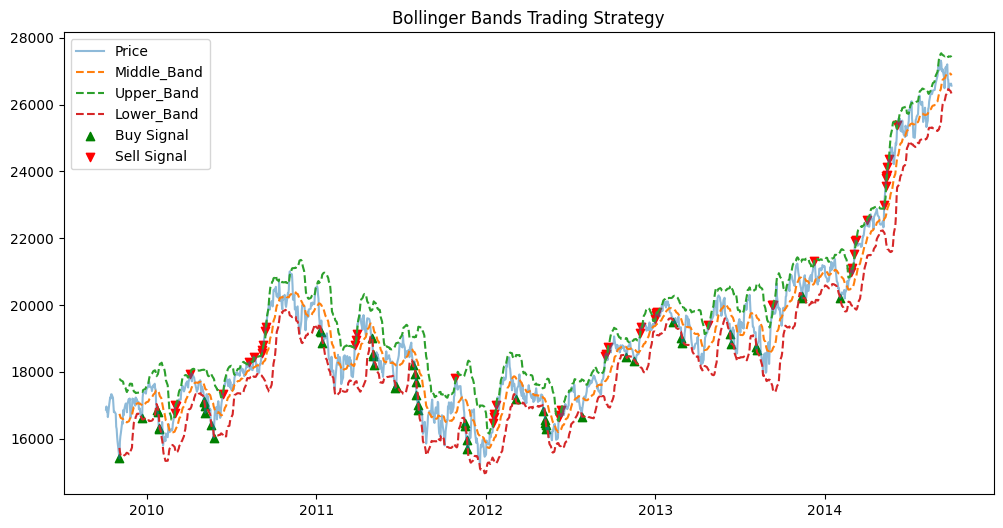

In [59]:
# Plot Bollinger Bands and trading signals for visualisation the plan 

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Price', alpha=0.5)
plt.plot(df['Middle_Band'], label='Middle_Band', linestyle='--')
plt.plot(df['Upper_Band'], label='Upper_Band', linestyle='--')
plt.plot(df['Lower_Band'], label='Lower_Band', linestyle='--')

# Plot buy signals as green arrows
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], marker='^', color='g', label='Buy Signal', alpha=1)

# Plot sell signals as red arrows
plt.scatter(df.index[df['Signal'] == +1], df['Close'][df['Signal'] == +1], marker='v', color='r', label='Sell Signal', alpha=1)

plt.title('Bollinger Bands Trading Strategy')
plt.legend()
plt.show()

### Return Calculation:

$$ Cumulative\_ Return = \frac{Value\_ Holding + Cumulative\_ Sell - Cumulative\_ Buy}{Cumulative\_ Buy} $$

**Position sizing shall be considered later

In [60]:
# Follow the buy and sale signals with the same positon sizing for every crossing for now
 
# Cash column representing the amount of money change from our pocket, where positive is sell trade and negative is buy trade
df['Cash'] = df['Signal'] * df['Close']

# Delete unnecessary columns
del df['Open']
del df['High']
del df['Low']
del df['Middle_Band']

# Calculate current asset value held
df['Current_holding'] = df['Asset_owned'] * df['Close']

# Calculate 'Return'column representing cumulative return for each date
df['Return'] = (df['Asset_sold'] - df['Cash_invested'] + df['Current_holding'])/df['Cash_invested']


ledger = df.loc[df['Signal'] != 0]
trading_balance = ledger['Cash'].sum()
asset_owned = ledger['Signal'].sum()

print(trading_balance) #net cash situation if we buy/sell 1 unit of the asset each time
print(asset_owned) # check how many units of the asset we own/owe
print(ledger)

103736.79000000001
0
               Close    Upper_Band    Lower_Band  Signal  Asset_owned  \
Date                                                                    
2009-11-03  15404.94  17758.960095  15719.407905      -1            1   
2009-12-21  16601.20  17399.129072  16615.443928      -1            2   
2010-01-22  16859.68  17866.554083  17034.911917      -1            3   
2010-01-25  16780.46  17933.370911  16923.030089      -1            4   
2010-01-27  16289.82  18092.288460  16657.033540      -1            5   
...              ...           ...           ...     ...          ...   
2014-05-14  23815.12  23690.789231  21797.242769       1            4   
2014-05-15  23905.60  23885.110797  21730.585203       1            3   
2014-05-16  24121.74  24103.679802  21675.697198       1            2   
2014-05-19  24363.05  24337.861319  21650.097681       1            1   
2014-06-06  25396.46  25314.416614  23526.543386       1            0   

                Cash  Cash_in

In [61]:
#Plot graph of cumulative return here

In [62]:
# Calculate annual return and standard deviation of the returns

# Annual_date_index list will contain index for dates necessary for annual return calculations 
Annual_date_index = []

# List of lists of indices for monthly returns in each year
index_for_SD = {}

# End_year and Start_year were initialised at the beginning
for order in range(End_year-Start_year+1):
    # Include the index from the first day to the last day
    # There are about 250 trading days in a year 
    # Sometimes the same date can be on weekends so calling data using index is easier
    # Wrote try & except in case out of bound error
    try :
        Annual_date_index.append(df['Signal'].index[250*order]) 
    except :
        try :
            Annual_date_index.append(df['Signal'].index[249*order])
        except :
            Annual_date_index.append(df['Signal'].index[248*order])

    monthly_date_index = []

    for month in range(13):
    # There are about 21 trading days in a month 
    # Sometimes the same date can be on weekends so calling data using index is easier
    # Wrote try & except in case out of bound error
        try :
            monthly_date_index.append(df['Signal'].index[21*(month + 12*order)]) 
        except :
            try :
                monthly_date_index.append(df['Signal'].index[20*(month + 12*order)])
            except:
                continue #for the last 'order' which would be out of bound for a year
    
    if order == End_year-Start_year:
        break       # To not add more element during the last 'order' 

    index_for_SD[f"Year {order+1} indices"] = monthly_date_index

print(index_for_SD)
print(Annual_date_index)


{'Year 1 indices': [Timestamp('2009-10-05 00:00:00'), Timestamp('2009-11-05 00:00:00'), Timestamp('2009-12-04 00:00:00'), Timestamp('2010-01-07 00:00:00'), Timestamp('2010-02-06 00:00:00'), Timestamp('2010-03-10 00:00:00'), Timestamp('2010-04-12 00:00:00'), Timestamp('2010-05-12 00:00:00'), Timestamp('2010-06-10 00:00:00'), Timestamp('2010-07-09 00:00:00'), Timestamp('2010-08-09 00:00:00'), Timestamp('2010-09-07 00:00:00'), Timestamp('2010-10-07 00:00:00')], 'Year 2 indices': [Timestamp('2010-10-07 00:00:00'), Timestamp('2010-11-05 00:00:00'), Timestamp('2010-12-07 00:00:00'), Timestamp('2011-01-06 00:00:00'), Timestamp('2011-02-07 00:00:00'), Timestamp('2011-03-09 00:00:00'), Timestamp('2011-04-07 00:00:00'), Timestamp('2011-05-11 00:00:00'), Timestamp('2011-06-09 00:00:00'), Timestamp('2011-07-08 00:00:00'), Timestamp('2011-08-08 00:00:00'), Timestamp('2011-09-09 00:00:00'), Timestamp('2011-10-11 00:00:00')], 'Year 3 indices': [Timestamp('2011-10-11 00:00:00'), Timestamp('2011-11-14 

In [63]:
# Find the annual SD_porfolio by calculating standard deviation of monthly returns in each year 
# Then obtain the annual SD for that year by combining the monthly SDs 
# Since varince of independent variables add up (assuming the SD from monthly returns represent monthly SD)

df_for_SD = pd.DataFrame(index_for_SD)

for i in range(1,len(Annual_date_index)):
    
    df_for_SD[f"Year {i} returns"] = 0 #initialise the return columns

    for month in range(1,13): 

        Monthly_investment = df.loc[df_for_SD.loc[month,f'Year {i} indices'],"Cash_invested"] - df.loc[df_for_SD.loc[month-1,f'Year {i} indices'],'Cash_invested']
        Monthly_sell = df.loc[df_for_SD.loc[month,f'Year {i} indices'],'Asset_sold'] - df.loc[df_for_SD.loc[month-1,f'Year {i} indices'],'Asset_sold']
        Monthly_holding = df.loc[df_for_SD.loc[month,f'Year {i} indices'],'Current_holding'] - df.loc[df_for_SD.loc[month-1,f'Year {i} indices'],'Current_holding']

        Monthly_return = (Monthly_holding + Monthly_sell- Monthly_investment)/ Monthly_investment
        df_for_SD.loc[month,f"Year {i} returns"] = Monthly_return


print(df_for_SD)


   Year 1 indices Year 2 indices Year 3 indices Year 4 indices Year 5 indices  \
0      2009-10-05     2010-10-07     2011-10-11     2012-10-11     2013-10-17   
1      2009-11-05     2010-11-05     2011-11-14     2012-11-12     2013-11-18   
2      2009-12-04     2010-12-07     2011-12-14     2012-12-13     2013-12-17   
3      2010-01-07     2011-01-06     2012-01-11     2013-01-14     2014-01-16   
4      2010-02-06     2011-02-07     2012-02-10     2013-02-12     2014-02-14   
5      2010-03-10     2011-03-09     2012-03-13     2013-03-13     2014-03-19   
6      2010-04-12     2011-04-07     2012-04-13     2013-04-15     2014-04-21   
7      2010-05-12     2011-05-11     2012-05-14     2013-05-16     2014-05-22   
8      2010-06-10     2011-06-09     2012-06-12     2013-06-14     2014-06-20   
9      2010-07-09     2011-07-08     2012-07-11     2013-07-15     2014-07-21   
10     2010-08-09     2011-08-08     2012-08-09     2013-08-14     2014-08-21   
11     2010-09-07     2011-0

/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/3253651789.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  Monthly_return = (Monthly_holding + Monthly_sell- Monthly_investment)/ Monthly_investment
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/3253651789.py:19: RuntimeWarning: invalid value encountered in double_scalars
  Monthly_return = (Monthly_holding + Monthly_sell- Monthly_investment)/ Monthly_investment
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/3253651789.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  Monthly_return = (Monthly_holding + Monthly_sell- Monthly_investment)/ Monthly_investment
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/3253651789.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  Monthly_return = (Monthly_holding + Monthly_sell- Monthly_investment)/ Monthly_investment
/var/folders/sh/jlgn2vb117v7tyhz7c68zk880000gn/T/ipykernel_949/32

Realised that perhaps calculating standard deviation for each year to obtain Sharpe ratios for each year, hoping that it would reveal some trend might not be a good idea. The buy and sell signals for our strategy are too far in between the months. As a result, there were many months that have only one or less activity, which suggests that the timeframe is too short.

Therefore, we are just going to calculate the Sharpe ratio for the whole training data set.

In [70]:
# Initialise the annual return list
Annual_returns = []

for x in range(1,len(Annual_date_index)):

    Annual_investment = df.loc[Annual_date_index[x],'Cash_invested'] - df.loc[Annual_date_index[x-1],'Cash_invested']
    Annual_sell = df.loc[Annual_date_index[x],'Asset_sold'] - df.loc[Annual_date_index[x-1],'Asset_sold']
    Annual_holding = df.loc[Annual_date_index[x],'Current_holding'] - df.loc[Annual_date_index[x-1],'Current_holding']

    Annual_return = (Annual_holding + Annual_sell - Annual_investment)/ Annual_investment 
    Annual_returns.append(Annual_return)
    
# SD_porfolio of the training data set
SD_porfolio = np.std(Annual_returns)

# Retreive Porfolio_return of the training data set

index = Annual_date_index[-1]
Porfolio_return = df.loc[index,"Return"] #Cumulative return happens to be the return of the training data

print(Annual_returns)
print(SD_porfolio)
print(Porfolio_return)


[0.09395623623749394, -0.08948297505402979, 0.2534259356581112, 0.11707977382394115, 0.7200224040080666]
0.27327422696677356
0.117718049760757


$$ Sharpe\_ Ratio = \frac{Portfolio\_ Return - Risk\_ Free\_ Rate}{SD\_ Portfolio} $$
,where $\hspace{12 em}$ $ Risk\_ Free\_ Rate = \displaystyle\frac{Face\_ Value - Purchase\_ Price} {Purchase\_ Price} $

In [71]:
# Performance measurement -> using Sharpe ratio for the whole training data set since our strategy is slow in timeframe

# Calculate the risk free rate for the period that training data set covers 

risk_free = 0.03 #to be calculated/acquired, chose 0.03 for now to see the vibes

Sharpe_ratio = (Porfolio_return - risk_free)/SD_porfolio

print(Sharpe_ratio)       

0.32098910583112666


In [ ]:
# Test it on the other chuck of time period 

In [ ]:
# Then try on other equities/ different asset types